# Прогнозирование температуры с использованием уравнения теплового баланса

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # Для решения ОДУ

from tqdm import tqdm

## Загрузка и подготовка данных

In [35]:
data = pd.read_csv('../data/sample_transformed_data.csv', usecols=['time', 'temp_ice', 'temp_outside', 'temp_inside', 'power_compressors'])[10000:]


# Преобразование времени и интерполяция
data = (data
    .assign(time=lambda df: pd.to_datetime(df['time']))
    .drop_duplicates(subset=['time'])
    .set_index('time')
    .pipe(lambda df: df.reindex(pd.date_range(start=df.index.min(), 
                                              end=df.index.max(), 
                                              freq='1T')))
)

# Проверка на наличие пропусков и интерполяция
if data.isna().sum().any():
    data = data.interpolate(method='linear').dropna()

In [36]:
# Сброс индекса и добавление столбца времени в минутах от начала
data = data.reset_index(names=['time'])
data['time_minutes'] = (data['time'] - data['time'].min()).dt.total_seconds() / 60
time = data['time_minutes'].values                  # Время в минутах
T_air = data['temp_inside'].values                  # Внутренняя температура, °C
T_outside = data['temp_outside'].values             # Внешняя температура, °C
P_compressors = data['power_compressors'].values    # Мощность компрессоров, Вт

# Проверка равномерности временных шагов
dt_array = np.diff(time)
if not np.allclose(dt_array, dt_array[0]):
    raise ValueError("Временные шаги в данных не равномерны. Необходимо адаптировать код для неравномерных шагов.")
dt = 1  # шаг по времени в минутах

# Определение параметров модели

Для точного расчета теплового баланса льда в ледовой арене необходимо учитывать следующие параметры:

### **Физические параметры:**

1. **Теплоемкость льда (C_ice):**
   - **Удельная теплоемкость льда:** 2100 Дж/(кг·°C)
   - **Масса льда (mass_ice):** 30,000 кг
   - **Общая теплоемкость льда:** $C_{\text{ice}} = 2100 \times 30,000 = 63,000,000$ Дж/°C

2. **Коэффициенты теплопередачи:**
   - **Внутренняя теплопередача (h_in):** 10 Вт/(м²·°C)
   - **Внешняя теплопередача (h_out):** 2 Вт/(м²·°C)

3. **Эффективность системы охлаждения (eta):** 0.7

4. **Площадь ледовой арены (area):** 1800 м²

5. **Масса льда (mass_ice):** 30,000 кг

### **Дополнительные параметры:**

6. **Теплоемкость воды (C_water):** 4186 Дж/(кг·°C) *(стандартное значение)*

7. **Масса заливаемой воды (mass_water):** 
   - **Оценка:** Типичная масса воды для заливки льда может варьироваться в зависимости от размеров арены. Для арены площадью 1800 м² и средней толщины льда (например, 5 см) масса воды может быть рассчитана как:
     $$
     mass_{\text{water}} = area \times thickness \times \rho_{\text{water}} = 1800 \times 0.05 \times 1000 = 90,000 \text{ кг}
     $$
     Однако, если заливается только часть арены или толщина меньше, скорректируйте значение соответственно. Для начала можно взять **mass_water = 2000 кг** как условное значение и далее уточнять по реальным данным.

8. **Температура заливаемой воды (T_water):** 50 °C *(типичное значение для горячей воды при заливке)*

9. **Временная задержка системы охлаждения (tau):** 15 минут

10. **Характерное время затухания (tau_d):** 30 минут

11. **Равновесная температура льда (T_eq):** -5 °C *(может быть скорректировано в зависимости от реальных условий)*

12. **Время заливки (duration_resurfacing):** 10 минут *(условное значение; уточняется по практике)*

13. **Моменты времени заливки (resurfacing_times):** [1000, 2000, 3000] минут *(примерные значения; замените на реальные или определите на основе данных)*

### **Параметры, связанные с датасетом:**

14. **Температура внутреннего воздуха (T_inside):** из `temp_inside`

15. **Температура наружного воздуха (T_outside):** из `temp_outside`

16. **Температура льда (T_ice):** из `temp_ice`

17. **Мощность компрессоров (P_compressors):** из `power_compressors`

### **Недостающие параметры (нужно добавить):**

1. **C_water:** Удельная теплоемкость воды. Обычно принимается как 4186 Дж/(кг·°C).

2. **mass_water:** Масса заливаемой воды. Если точные данные отсутствуют, можно использовать типичные значения или оценить на основе размеров арены и толщины заливаемого слоя воды.

3. **T_water:** Температура заливаемой воды. Обычно около 50 °C, но лучше уточнить.

4. **tau (временная задержка):** Задержка системы охлаждения. Вы уже указали 15 минут.

5. **tau_d (характерное время затухания):** Вы уже указали 30 минут.

6. **T_eq:** Равновесная температура льда. Вы уже указали -5 °C.

7. **resurfacing_times:** Моменты времени, когда происходит заливка льда. Если нет точных данных, можно определить их на основе данных о резких изменениях температуры льда.

8. **duration_resurfacing:** Время, на протяжении которого происходит заливка. Обычно это несколько минут (например, 10 минут).

## 3. Рекомендации по подбору недостающих параметров

### **1. Теплоемкость воды (C_water):**

Используйте стандартное значение:

```python
C_water = 4186  # Дж/(кг·°C)
```

### **2. Масса заливаемой воды (mass_water):**

Если нет точных данных, примите условное значение и при необходимости скорректируйте:

```python
mass_water = 2000  # кг
```

### **3. Температура заливаемой воды (T_water):**

Используйте типичное значение:

```python
T_water = 50  # °C
```

### **4. Моменты времени заливки (resurfacing_times):**

Если нет точных данных, определите их по резким изменениям температуры льда или используйте условные значения для тестирования:

```python
resurfacing_times = [1000, 2000, 3000]  # В минутах (пример)
```

### **5. Длительность заливки (duration_resurfacing):**

Примите условное значение, например, 10 минут:

```python
duration_resurfacing = 10  # минут
```



In [37]:
# Физические параметры
mass_ice = 30000         # кг, масса ледового покрытия
C_ice = 2100 * mass_ice  # Дж/°C, теплоёмкость льда
h_in = 10                # Вт/(м²·°C)
h_out = 2                # Вт/(м²·°C)
eta = 0.7                # КПД системы охлаждения
area = 1800              # м², площадь ледовой арены

# Дополнительные параметры
C_water = 4186               # Дж/(кг·°C), удельная теплоемкость воды
mass_water = 2000            # кг, масса заливаемой воды (уточните при необходимости)
T_water = 50                 # °C, температура заливаемой воды
duration_resurfacing = 10    # минут, длительность заливки
tau = 15                     # минут, временная задержка влияния компрессоров на температуру льда
tau_d = 30                   # минут, характерное время затухания
T_eq = -5                    # °C, равновесная температура льда

# Моменты времени заливки (в минутах)
resurfacing_times = [1000, 2000, 3000]  # Пример: замените на реальные значения

# Перевод моментов времени заливки в индексы
resurfacing_indices = [int(t / dt) for t in resurfacing_times]

In [38]:
# Инициализация массива для температуры льда
n_points = len(time)
T_ice = np.zeros(n_points)
T_ice[0] = data['temp_ice'].iloc[0]

## Функции для вычисления тепловых потоков

In [39]:
# 4. Моделирование задержки мощности компрессоров
def delayed_power(P_power, delay_steps):
    P_delayed = np.zeros_like(P_power)
    if delay_steps > 0:
        P_delayed[delay_steps:] = P_power[:-delay_steps]
        P_delayed[:delay_steps] = P_power[0]  # Заполняем первые значения начальными данными
    else:
        P_delayed = P_power
    return P_delayed

delay_steps = int(tau / dt)
P_comp_delayed = delayed_power(P_compressors, delay_steps)

# 5. Функция для расчета теплового потока от заливки
def resurfacing_heat_flow(T_ice_current, mass_water, C_water, T_water, duration_resurfacing):
    # Энергия, вводимая при заливке
    Q = mass_water * C_water * (T_water - T_ice_current)  # Дж
    # Преобразование энергии в тепловой поток (Вт) за время заливки
    q_resurfacing = Q / (duration_resurfacing * 60)  # Вт (поскольку duration_resurfacing в минутах)
    return q_resurfacing

## Определение функции, описывающей ОДУ

In [40]:
# 6. Функция для расчёта производной температуры
def dTdt(T_current, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices):
    if idx >= n_points:
        idx = n_points - 1

    # Текущие значения параметров
    T_air_current = T_air_array[idx]
    T_outside_current = T_outside_array[idx]
    P_comp_current = P_comp_array[idx]

    # Тепловые потоки
    q_conv = h_in * area * (T_air_current - T_current)
    q_ext = h_out * area * (T_outside_current - T_current)
    q_in = q_conv + q_ext
    q_out = eta * P_comp_current

    # Проверка на заливку
    if idx in resurfacing_indices:
        q_in += resurfacing_heat_flow(T_current, mass_water, C_water, T_water, duration_resurfacing)

    # Затухающий процесс
    q_damping = (C_ice / tau_d) * (T_current - T_eq)

    # Дифференциальное уравнение
    dT = (q_in - q_out - q_damping) / C_ice  # °C/мин

    return dT

## Решение дифференциального уравнения

In [41]:
# 7. Решение дифференциального уравнения методом Эйлера
for i in tqdm(range(1, n_points)):
    T_prev = T_ice[i-1]
    dT = dTdt(T_prev, i-1, T_air, T_outside, P_comp_delayed, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)
    T_ice[i] = T_prev + dT * dt  # °C

100%|██████████| 34083/34083 [00:00<00:00, 574742.14it/s]


## Визуализация результатов

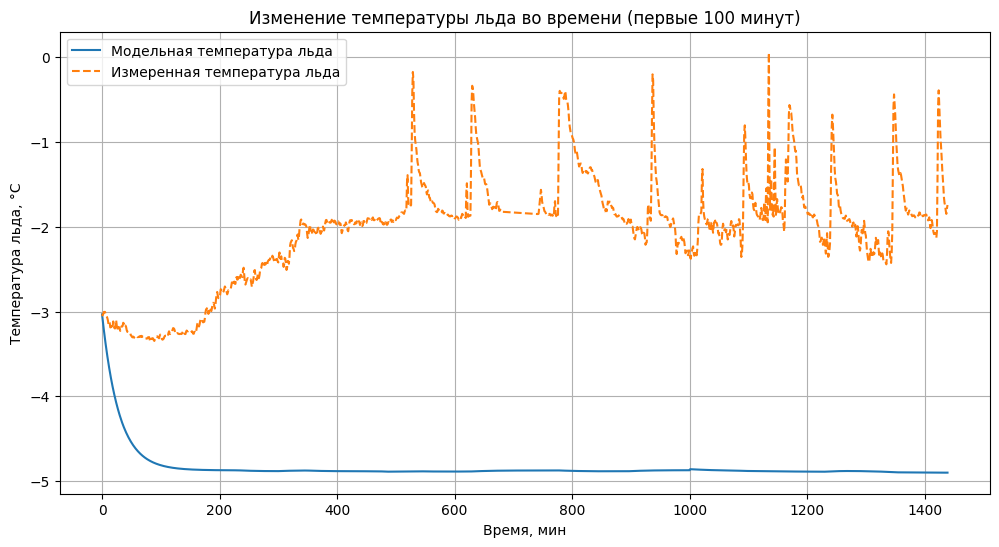

In [43]:
# 8. Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(time[:1440], T_ice[:1440], label='Модельная температура льда')
plt.plot(time[:1440], data['temp_ice'].values[:1440], label='Измеренная температура льда', linestyle='--')
plt.xlabel('Время, мин')
plt.ylabel('Температура льда, °C')
plt.title('Изменение температуры льда во времени (первые 100 минут)')
plt.grid(True)
plt.legend()
plt.show()

In [51]:
# Вычисление средней квадратичной ошибки
mse = np.mean((T_ice[:1440] - data['temp_ice'].values[:1440])**2)
print(f"Среднеквадратичная ошибка (MSE) первых 2880 минут: {mse:.4f} °C²")

Среднеквадратичная ошибка (MSE) первых 1440 минут: 8.3724 °C²


In [52]:
# Определение моментов заливки по резким повышением температуры льда
temperature_diff = data['temp_ice'].diff().abs()
threshold = temperature_diff.mean() + 3 * temperature_diff.std()  # Порог для определения резких изменений
resurfacing_times_detected = data['time_minutes'][temperature_diff > threshold].tolist()

# Перевод в индексы
resurfacing_indices = [int(t / dt) for t in resurfacing_times_detected]

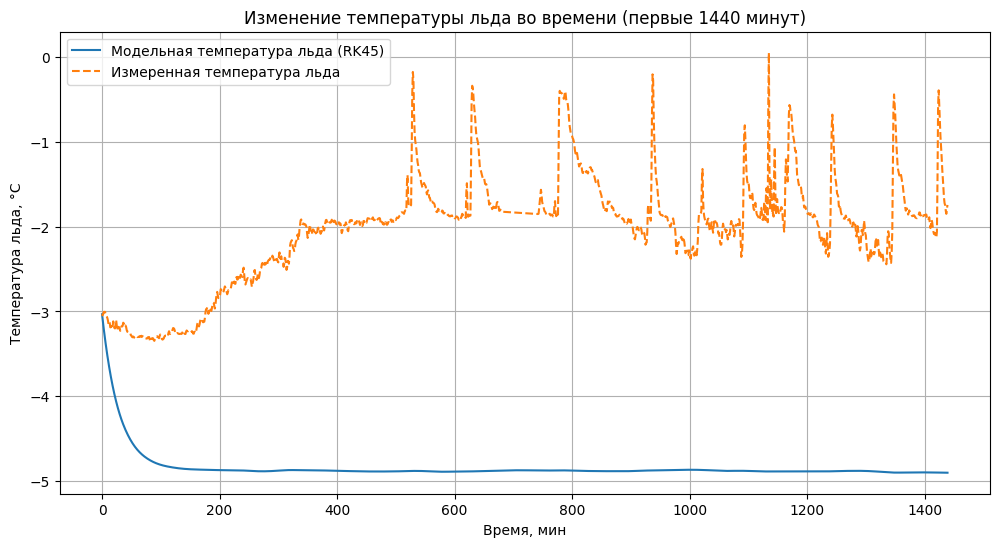

In [55]:
from scipy.integrate import solve_ivp

# Функция для интегратора
def ode_system(t, T, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices, dt):
    idx = int(t / dt)
    if idx >= n_points:
        idx = n_points - 1
    return dTdt(T, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)

# Начальные условия
T0 = T_ice[0]

# Решение ОДУ
solution = solve_ivp(
    fun=lambda t, y: ode_system(t, y, T_air, T_outside, P_comp_delayed, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices, dt),
    t_span=(time[0], time[-1]),
    y0=[T0],
    t_eval=time,
    method='RK45'
)

# Получение результатов
T_ice = solution.y[0]

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(time[:1440], T_ice[:1440], label='Модельная температура льда (RK45)')
plt.plot(time[:1440], data['temp_ice'].values[:1440], label='Измеренная температура льда', linestyle='--')
plt.xlabel('Время, мин')
plt.ylabel('Температура льда, °C')
plt.title('Изменение температуры льда во времени (первые 1440 минут)')
plt.grid(True)
plt.legend()
plt.show()


In [56]:
from scipy.optimize import minimize

# Целевая функция для минимизации (MSE)
def objective(params, T_air, T_outside, P_compressors, T_measured, resurfacing_indices, dt, n_points):
    h_in, h_out, eta, mass_water = params
    C_ice = 2100 * mass_ice
    # Инициализация модели с текущими параметрами
    T_model = np.zeros(n_points)
    T_model[0] = data['temp_ice'].iloc[0]
    P_comp_delayed = delayed_power(P_compressors, int(tau / dt))
    for i in range(1, n_points):
        T_prev = T_model[i-1]
        q_conv = h_in * area * (T_air[i] - T_prev)
        q_ext = h_out * area * (T_outside[i] - T_prev)
        q_in = q_conv + q_ext
        q_out = eta * P_comp_delayed[i]
        if i in resurfacing_indices:
            q_in += resurfacing_heat_flow(T_prev, mass_water, C_water, T_water, duration_resurfacing)
        q_damping = (C_ice / tau_d) * (T_prev - T_eq)
        dT = (q_in - q_out - q_damping) / C_ice
        T_model[i] = T_prev + dT * dt
    # Вычисление средней квадратичной ошибки
    mse = np.mean((T_model[:100] - T_measured[:100])**2)
    return mse

# Начальные догадки для параметров
initial_guess = [10, 2, 0.7, 2000]

# Ограничения для параметров (при необходимости)
bounds = [(0, 20), (0, 10), (0.5, 1.0), (500, 5000)]

# Целевая функция
T_measured = data['temp_ice'].values[:100]  # Используйте реальные измерения
resurfacing_indices_subset = [idx for idx in resurfacing_indices if idx < 100]

# Оптимизация
result = minimize(
    objective, 
    initial_guess, 
    args=(T_air[:100], T_outside[:100], P_compressors[:100], T_measured, resurfacing_indices_subset, dt, 100),
    bounds=bounds
)

# Оптимизированные параметры
h_in_opt, h_out_opt, eta_opt, mass_water_opt = result.x
print(f"Оптимизированные параметры:\nh_in = {h_in_opt:.2f} Вт/(м²·°C)\nh_out = {h_out_opt:.2f} Вт/(м²·°C)\neta = {eta_opt:.2f}\nmass_water = {mass_water_opt:.2f} кг")

Оптимизированные параметры:
h_in = 20.00 Вт/(м²·°C)
h_out = 10.00 Вт/(м²·°C)
eta = 0.50
mass_water = 2000.00 кг


In [49]:
print('Модель:', list(T_ice[:1440]), '\n','Фактические значения:', list(data['temp_ice'].values[:1440]))

Модель: [-3.033203125, -3.095708947670558, -3.156106240976916, -3.21448029765187, -3.270881842046798, -3.325385783112809, -3.378056024901055, -3.428954319145211, -3.4781403385607654, -3.5256717457685145, -3.571604262076811, -3.6159917317676573, -3.658886186397716, -3.700337905026557, -3.7403954732340865, -3.7791058409679232, -3.8165143765353506, -3.852478771738101, -3.887059732725642, -3.920479013188909, -3.952773662196168, -3.9839858754343194, -4.014148487346619, -4.043299138831116, -4.071466921198382, -4.0986897706500836, -4.124996197348172, -4.150419852970979, -4.174974256908999, -4.198699232852904, -4.2216327619495715, -4.243774427843433, -4.2651880732579865, -4.285868909388912, -4.3058598154547445, -4.325191727225938, -4.343697520008096, -4.361408538788707, -4.3785245478647825, -4.3950655815075965, -4.411051005338239, -4.426499532623011, -4.441429238580917, -4.4558575981046875, -4.46980149271566, -4.483277238707642, -4.496300602848238, -4.508886817745973, -4.521050605588677, -4.53

In [30]:
data['temp_ice'].values[:100]

array([-3.03320312, -3.046875  , -3.02929688, -3.00585938, -3.00585938,
       -3.00488281, -3.03027344, -3.05078125, -3.06054688, -3.07714844,
       -3.10546875, -3.15136719, -3.12597656, -3.13378906, -3.1875    ,
       -3.18554688, -3.17382812, -3.20410156, -3.17675781, -3.1171875 ,
       -3.15429688, -3.1953125 , -3.20019531, -3.15234375, -3.1015625 ,
       -3.16894531, -3.22460938, -3.19042969, -3.18164062, -3.18652344,
       -3.19628906, -3.22851562, -3.21777344, -3.17578125, -3.17578125,
       -3.17089844, -3.1328125 , -3.14160156, -3.17773438, -3.17578125,
       -3.16601562, -3.18457031, -3.22070312, -3.23925781, -3.23925781,
       -3.24121094, -3.24511719, -3.24316406, -3.25390625, -3.28125   ,
       -3.28613281, -3.29980469, -3.3046875 , -3.29589844, -3.30029297,
       -3.31005859, -3.31542969, -3.30761719, -3.29882812, -3.29394531,
       -3.30175781, -3.30175781, -3.30078125, -3.29785156, -3.29101562,
       -3.29785156, -3.29492188, -3.28710938, -3.29980469, -3.29

## Вывод
Зная уравнение теплового баланса и имея данные о текущем состоянии системы, мы можем прогнозировать температуру льда в будущем. Полученная модель позволяет рассчитать изменение температуры льда на интервале времени и подготовить данные для обучения PINN. Физически информированные нейронные сети интегрируют физические законы в структуру нейронной сети, что повышает точность и эффективность прогнозирования.

Следующие шаги:

- Калибровка модели: Подбор параметров модели на основе экспериментальных данных для повышения точности.
- Обучение PINN: Использование подготовленных данных для обучения нейронной сети, учитывающей физические принципы.
- Валидация модели: Сравнение результатов модели с фактическими измерениями для оценки точности и надежности.

100%|██████████| 34083/34083 [00:00<00:00, 381540.54it/s]


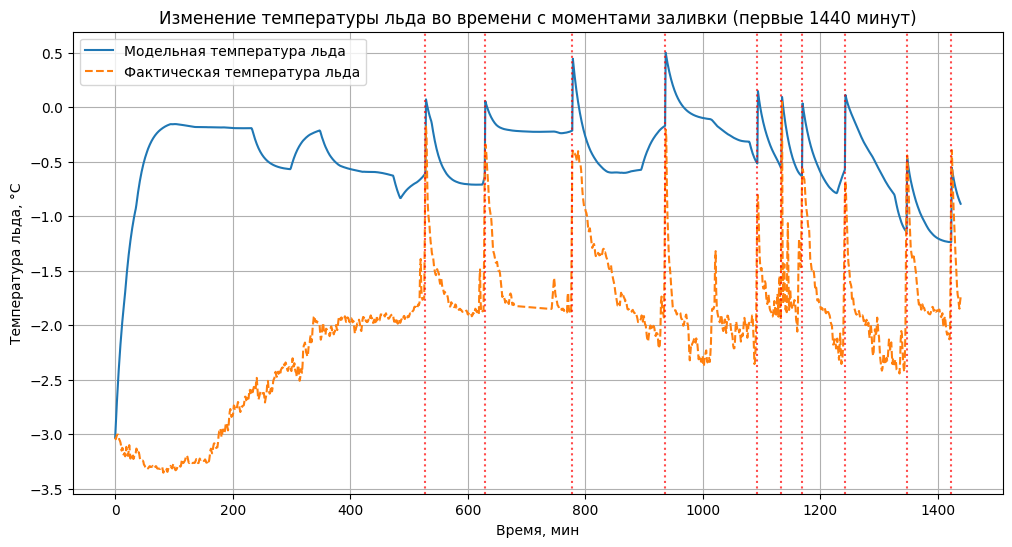

Оптимизированные параметры:
h_in = 5.20 Вт/(м²·°C)
h_out = 0.00 Вт/(м²·°C)
eta = 0.50
mass_water = 5000.00 кг
Среднеквадратичная ошибка (MSE) первых 1440 минут: 2.9836 °C²


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
from datetime import timedelta

# 1. Загрузка и подготовка данных
data = pd.read_csv('../data/sample_transformed_data.csv', 
                   usecols=['time', 'temp_ice', 'temp_outside', 'temp_inside', 'power_compressors'])[10000:]

# Преобразование времени и интерполяция
data = (data
    .assign(time=lambda df: pd.to_datetime(df['time']))
    .drop_duplicates(subset=['time'])
    .set_index('time')
    .pipe(lambda df: df.reindex(pd.date_range(start=df.index.min(), 
                                              end=df.index.max(), 
                                              freq='1T')))
)

# Обработка аномальных значений и интерполяция
data = (data
    .assign(temp_ice=lambda df: np.where(df['temp_ice'].between(-10, 3), df['temp_ice'], np.NaN))
    .fillna(method='ffill')
)

# Добавление столбца времени в минутах от начала
data = data.reset_index(names=['time'])
data['time_minutes'] = (data['time'] - data['time'].min()).dt.total_seconds() / 60
time = data['time_minutes'].values                  # Время в минутах
T_air = data['temp_inside'].values                  # Внутренняя температура, °C
T_outside = data['temp_outside'].values             # Внешняя температура, °C
P_compressors = data['power_compressors'].values    # Мощность компрессоров, Вт

# Проверка равномерности временных шагов
dt_array = np.diff(time)
if not np.allclose(dt_array, dt_array[0]):
    raise ValueError("Временные шаги в данных не равномерны. Необходимо адаптировать код для неравномерных шагов.")
dt = 1  # шаг по времени в минутах

# 2. Определение параметров модели
# Физические параметры
mass_ice = 30000         # кг, масса ледового покрытия
C_ice = 2100 * mass_ice  # Дж/°C, теплоёмкость льда
h_in = 10                # Вт/(м²·°C)
h_out = 2                # Вт/(м²·°C)
eta = 0.7                # КПД системы охлаждения
area = 1800              # м², площадь ледовой арены

# Дополнительные параметры
C_water = 4186              # Дж/(кг·°C), удельная теплоемкость воды
mass_water = 2000            # кг, масса заливаемой воды (уточните при необходимости)
T_water = 50                 # °C, температура заливаемой воды
duration_resurfacing = 10    # минут, длительность заливки
tau = 15                     # минут, временная задержка влияния компрессоров на температуру льда
tau_d = 30                   # минут, характерное время затухания
T_eq = -5                    # °C, равновесная температура льда

# 3. Определение моментов заливки (resurfacing)
# Обработка аномальных значений уже выполнена выше

# Дифференцируем, экспоненциально сглаженный ряд для нахождения заливки
data['diff'] = data['temp_ice'].ewm(span=60).mean().diff()

# Определение заливок, где разница превышает порог 0.03°C
data['flood'] = np.where(data['diff'] > 0.03, 1, 0)

# Создание признака для подсчёта времени между заливками
data['diff_time'] = timedelta(minutes=30)

# Подсчёт правильного количества заливок
# Убираем заливки, которые произошли менее чем через 30 минут после предыдущей
flood_indices = data.index[data['flood'] == 1].tolist()
valid_flood_indices = []
last_flood_time = None

for idx in flood_indices:
    current_time = data.at[idx, 'time']
    if last_flood_time is None or (current_time - last_flood_time) >= timedelta(minutes=30):
        valid_flood_indices.append(idx)
        last_flood_time = current_time

# Обновление списка индексов заливок
resurfacing_indices = [int((data.index.get_loc(idx)) / dt) for idx in valid_flood_indices]

# 4. Инициализация массива для температуры льда
n_points = len(time)
T_ice = np.zeros(n_points)
T_ice[0] = data['temp_ice'].iloc[0]

# 5. Моделирование задержки мощности компрессоров
def delayed_power(P_power, delay_steps):
    P_delayed = np.zeros_like(P_power)
    if delay_steps > 0:
        P_delayed[delay_steps:] = P_power[:-delay_steps]
        P_delayed[:delay_steps] = P_power[0]  # Заполняем первые значения начальными данными
    else:
        P_delayed = P_power
    return P_delayed

delay_steps = int(tau / dt)
P_comp_delayed = delayed_power(P_compressors, delay_steps)

# 6. Функция для расчета теплового потока от заливки
def resurfacing_heat_flow(T_ice_current, mass_water, C_water, T_water, duration_resurfacing):
    # Энергия, вводимая при заливке
    Q = mass_water * C_water * (T_water - T_ice_current)  # Дж
    # Преобразование энергии в тепловой поток (Вт) за время заливки
    q_resurfacing = Q / (duration_resurfacing * 60)  # W (поскольку duration_resurfacing в минутах)
    return q_resurfacing

# 7. Функция для расчёта производной температуры
def dTdt(T_current, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices):
    if idx >= n_points:
        idx = n_points - 1

    # Текущие значения параметров
    T_air_current = T_air_array[idx]
    T_outside_current = T_outside_array[idx]
    P_comp_current = P_comp_array[idx]

    # Тепловые потоки
    q_conv = h_in * area * (T_air_current - T_current)       # W
    q_ext = h_out * area * (T_outside_current - T_current) # W
    q_in = q_conv + q_ext                                  # W
    if idx in resurfacing_indices:
        q_in += resurfacing_heat_flow(T_current, mass_water, C_water, T_water, duration_resurfacing)  # W
    q_out = eta * P_comp_current                           # W

    # Затухающий процесс
    q_damping = (C_ice / tau_d) * (T_current - T_eq)        # J/min

    # Корректировка единиц: перевод W в J/min
    q_in_J_per_min = q_in * 60                               # J/min
    q_out_J_per_min = q_out * 60                             # J/min

    # Дифференциальное уравнение
    dT = (q_in_J_per_min - q_out_J_per_min - q_damping) / C_ice  # °C/мин

    return dT

# 8. Решение дифференциального уравнения методом Эйлера
for i in tqdm(range(1, n_points)):
    T_prev = T_ice[i-1]
    dT = dTdt(T_prev, i-1, T_air, T_outside, P_comp_delayed, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)
    T_ice[i] = T_prev + dT * dt  # °C

# 9. Визуализация результатов
# Получение времени заливок для визуализации
flood_times = data['time_minutes'].iloc[resurfacing_indices].values

plt.figure(figsize=(12, 6))
plt.plot(time[:1440], T_ice[:1440], label='Модельная температура льда')
plt.plot(time[:1440], data['temp_ice'].values[:1440], label='Фактическая температура льда', linestyle='--')

# Добавление вертикальных линий на моменты заливки
for ft in flood_times:
    if ft < 1440:
        plt.axvline(x=ft, color='red', linestyle=':', alpha=0.7)

plt.xlabel('Время, мин')
plt.ylabel('Температура льда, °C')
plt.title('Изменение температуры льда во времени с моментами заливки (первые 1440 минут)')
plt.grid(True)
plt.legend()
plt.show()


# 10. Подготовка данных для обучения PINN (опционально)
prediction_data = pd.DataFrame({
    'time': time,
    'temp_ice': T_ice
})
prediction_data.to_csv('prediction_data.csv', index=False)

# 11. Калибровка параметров модели (опционально)
def objective(params, T_air, T_outside, P_compressors, T_measured, resurfacing_indices, dt, n_points):
    h_in, h_out, eta, mass_water = params
    C_ice = 2100 * mass_ice
    # Инициализация модели с текущими параметрами
    T_model = np.zeros(n_points)
    T_model[0] = data['temp_ice'].iloc[0]
    P_comp_delayed = delayed_power(P_compressors, int(tau / dt))
    for i in range(1, n_points):
        T_prev = T_model[i-1]
        q_conv = h_in * area * (T_air[i] - T_prev)
        q_ext = h_out * area * (T_outside[i] - T_prev)
        q_in = q_conv + q_ext
        if i in resurfacing_indices:
            q_in += resurfacing_heat_flow(T_prev, mass_water, C_water, T_water, duration_resurfacing)
        q_out = eta * P_comp_delayed[i]
        q_damping = (C_ice / tau_d) * (T_prev - T_eq)
        # Корректировка единиц
        q_in_J_per_min = q_in * 60
        q_out_J_per_min = q_out * 60
        # Расчёт dT
        dT = (q_in_J_per_min - q_out_J_per_min - q_damping) / C_ice
        T_model[i] = T_prev + dT * dt
    # Вычисление средней квадратичной ошибки
    mse = np.mean((T_model[:n_points] - T_measured[:n_points])**2)
    return mse

# Начальные догадки для параметров
initial_guess = [10, 2, 0.7, 2000]

# Ограничения для параметров (при необходимости)
bounds = [(0, 20), (0, 10), (0.5, 1.0), (500, 5000)]

# Целевая функция
T_measured = data['temp_ice'].values[:1440]  # Используйте реальные измерения
resurfacing_indices_subset = [idx for idx in resurfacing_indices if idx < 1440]

# Оптимизация
result = minimize(
    objective, 
    initial_guess, 
    args=(T_air[:1440], T_outside[:1440], P_compressors[:1440], T_measured, resurfacing_indices_subset, dt, 1440),
    bounds=bounds
)

# Оптимизированные параметры
h_in_opt, h_out_opt, eta_opt, mass_water_opt = result.x
print(f"Оптимизированные параметры:\nh_in = {h_in_opt:.2f} Вт/(м²·°C)\nh_out = {h_out_opt:.2f} Вт/(м²·°C)\neta = {eta_opt:.2f}\nmass_water = {mass_water_opt:.2f} кг")

# 12. Вычисление средней квадратичной ошибки (MSE)
mse = np.mean((T_ice[:1440] - data['temp_ice'].values[:1440])**2)
print(f"Среднеквадратичная ошибка (MSE) первых 1440 минут: {mse:.4f} °C²")

In [65]:
print('Модель:', list(T_ice[:1440]), '\n','Фактические значения:', list(data['temp_ice'].values[:1440]))

Модель: [-3.033203125, -2.915518631066822, -2.803963609314449, -2.6990647817825537, -2.5994187148585683, -2.50525119484349, -2.4162669019706104, -2.3321864192662285, -2.2527454243594875, -2.177693810416593, -2.1067949852504824, -2.0398250774221993, -1.9765723159268078, -1.916836328876268, -1.8604275290327548, -1.8071665815107634, -1.7568837857316884, -1.698249668358614, -1.6324387856019882, -1.5703478930986052, -1.511652151279112, -1.4564278883805597, -1.4042709029652938, -1.3551535136034292, -1.3086126119004566, -1.2647995277463229, -1.223368524051419, -1.1843585984032048, -1.1466667045830825, -1.110854830720907, -1.0774245850942257, -1.044623430379123, -1.0146480028268179, -0.9855876366482084, -0.9584850652888198, -0.9336968475351567, -0.8997392019998983, -0.8573178713279925, -0.8172690486324855, -0.7794646411035272, -0.7437838224087739, -0.7101122676639432, -0.6783413432937007, -0.6483687742845362, -0.6200975057184839, -0.5934359110678115, -0.5682972995756314, -0.5445994618652874, -

100%|██████████| 34083/34083 [00:00<00:00, 89586.24it/s]


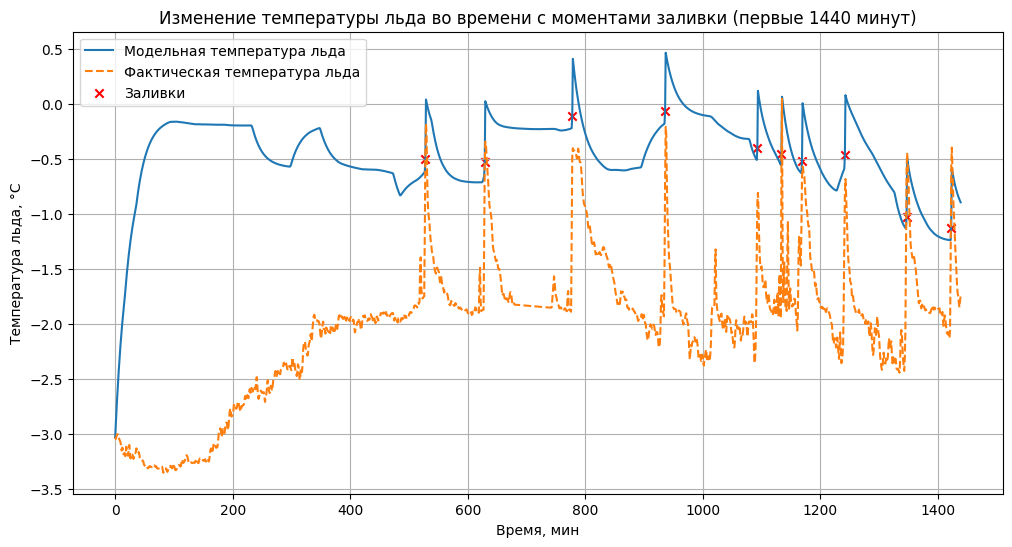

Оптимизированные параметры:
h_in = 5.20 Вт/(м²·°C)
h_out = 0.10 Вт/(м²·°C)
eta = 0.50
mass_water = 5000.00 кг
Среднеквадратичная ошибка (MSE) первых 1440 минут: 2.9777 °C²


In [69]:
# 1. Загрузка и подготовка данных
data = pd.read_csv('../data/sample_transformed_data.csv', 
                   usecols=['time', 'temp_ice', 'temp_outside', 'temp_inside', 'power_compressors'])[10000:]

# Преобразование времени и интерполяция
data = (data
    .assign(time=lambda df: pd.to_datetime(df['time']))
    .drop_duplicates(subset=['time'])
    .set_index('time')
    .pipe(lambda df: df.reindex(pd.date_range(start=df.index.min(), 
                                              end=df.index.max(), 
                                              freq='1T')))
)

# Обработка аномальных значений и интерполяция
data = (data
    .assign(temp_ice=lambda df: np.where(df['temp_ice'].between(-10, 3), df['temp_ice'], np.NaN))
    .fillna(method='ffill')
)

# Добавление столбца времени в минутах от начала
data = data.reset_index(names=['time'])
data['time_minutes'] = (data['time'] - data['time'].min()).dt.total_seconds() / 60
time = data['time_minutes'].values                  # Время в минутах
T_air = data['temp_inside'].values                  # Внутренняя температура, °C
T_outside = data['temp_outside'].values             # Внешняя температура, °C
P_compressors = data['power_compressors'].values    # Мощность компрессоров, Вт

# Проверка равномерности временных шагов
dt_array = np.diff(time)
if not np.allclose(dt_array, dt_array[0]):
    raise ValueError("Временные шаги в данных не равномерны. Необходимо адаптировать код для неравномерных шагов.")
dt = 1  # шаг по времени в минутах

# 2. Определение параметров модели
# Физические параметры
mass_ice = 30000         # кг, масса ледового покрытия
C_ice = 2100 * mass_ice  # Дж/°C, теплоёмкость льда
h_in = 10                # Вт/(м²·°C)
h_out = 2                # Вт/(м²·°C)
eta = 0.7                # КПД системы охлаждения
area = 1800              # м², площадь ледовой арены

# Дополнительные параметры
C_water = 4186              # Дж/(кг·°C), удельная теплоемкость воды
mass_water = 2000            # кг, масса заливаемой воды (уточните при необходимости)
T_water = 50                 # °C, температура заливаемой воды
duration_resurfacing = 10    # минут, длительность заливки
tau = 15                     # минут, временная задержка влияния компрессоров на температуру льда
tau_d = 30                   # минут, характерное время затухания
T_eq = -5                    # °C, равновесная температура льда

# 3. Определение моментов заливки (resurfacing)
# Дифференцируем, экспоненциально сглаженный ряд для нахождения заливки
data['diff'] = data['temp_ice'].ewm(span=60).mean().diff()

# Определение заливок, где разница превышает порог 0.03°C
data['flood'] = np.where(data['diff'] > 0.03, 1, 0)

# Создание признака для подсчёта времени между заливками
data['diff_time'] = timedelta(minutes=30)

# Подсчёт правильного количества заливок
# Убираем заливки, которые произошли менее чем через 30 минут после предыдущей
flood_indices = data.index[data['flood'] == 1].tolist()
valid_flood_indices = []
last_flood_time = None

for idx in flood_indices:
    current_time = data.at[idx, 'time']
    if last_flood_time is None or (current_time - last_flood_time) >= timedelta(minutes=30):
        valid_flood_indices.append(idx)
        last_flood_time = current_time

# Обновление списка индексов заливок
resurfacing_indices = [int((data.index.get_loc(idx)) / dt) for idx in valid_flood_indices]

# 4. Инициализация массива для температуры льда
n_points = len(time)
T_ice = np.zeros(n_points)
T_ice[0] = data['temp_ice'].iloc[0]

# 5. Моделирование задержки мощности компрессоров
def delayed_power(P_power, delay_steps):
    P_delayed = np.zeros_like(P_power)
    if delay_steps > 0:
        P_delayed[delay_steps:] = P_power[:-delay_steps]
        P_delayed[:delay_steps] = P_power[0]  # Заполняем первые значения начальными данными
    else:
        P_delayed = P_power
    return P_delayed

delay_steps = int(tau / dt)
P_comp_delayed = delayed_power(P_compressors, delay_steps)

# 6. Функция для расчета теплового потока от заливки
def resurfacing_heat_flow(T_ice_current, mass_water, C_water, T_water, duration_resurfacing):
    # Энергия, вводимая при заливке
    Q = mass_water * C_water * (T_water - T_ice_current)  # Дж
    # Преобразование энергии в тепловой поток (Вт) за время заливки
    q_resurfacing = Q / (duration_resurfacing * 60)  # W (поскольку duration_resurfacing в минутах)
    return q_resurfacing

# 7. Функция для расчёта производной температуры
def dTdt(T_current, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices):
    if idx >= n_points:
        idx = n_points - 1

    # Текущие значения параметров
    T_air_current = T_air_array[idx]
    T_outside_current = T_outside_array[idx]
    P_comp_current = P_comp_array[idx]

    # Тепловые потоки
    q_conv = h_in * area * (T_air_current - T_current)       # W
    q_ext = h_out * area * (T_outside_current - T_current) # W
    q_in = q_conv + q_ext                                  # W
    if idx in resurfacing_indices:
        q_in += resurfacing_heat_flow(T_current, mass_water, C_water, T_water, duration_resurfacing)  # W
    q_out = eta * P_comp_current                           # W

    # Затухающий процесс
    q_damping = (C_ice / tau_d) * (T_current - T_eq)        # J/min

    # Корректировка единиц: перевод W в J/min
    q_in_J_per_min = q_in * 60                               # J/min
    q_out_J_per_min = q_out * 60                             # J/min

    # Дифференциальное уравнение
    dT = (q_in_J_per_min - q_out_J_per_min - q_damping) / C_ice  # °C/мин

    return dT

# 8. Реализация метода Рунге-Кутты 4-го порядка
def runge_kutta_step(T_prev, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices):
    def derivative(T, idx):
        return dTdt(T, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)
    
    k1 = derivative(T_prev, idx)
    k2 = derivative(T_prev + 0.5 * dt * k1, idx + int(dt/2))
    k3 = derivative(T_prev + 0.5 * dt * k2, idx + int(dt/2))
    k4 = derivative(T_prev + dt * k3, idx + dt)
    
    return T_prev + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

for i in tqdm(range(1, n_points)):
    T_prev = T_ice[i-1]
    T_ice[i] = runge_kutta_step(T_prev, i-1, T_air, T_outside, P_comp_delayed, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)

# 9. Визуализация результатов
# Получение времени заливок для визуализации
flood_times = data['time_minutes'].iloc[resurfacing_indices].values

plt.figure(figsize=(12, 6))
plt.plot(time[:1440], T_ice[:1440], label='Модельная температура льда')
plt.plot(time[:1440], data['temp_ice'].values[:1440], label='Фактическая температура льда', linestyle='--')

# Добавление точек заливки
resurfacing_indices_subset = [idx for idx in resurfacing_indices if idx < 1440]
plt.scatter(time[resurfacing_indices_subset], T_ice[resurfacing_indices_subset], color='red', label='Заливки', marker='x')

plt.xlabel('Время, мин')
plt.ylabel('Температура льда, °C')
plt.title('Изменение температуры льда во времени с моментами заливки (первые 1440 минут)')
plt.grid(True)
plt.legend()
plt.show()

# 10. Подготовка данных для обучения PINN (опционально)
prediction_data = pd.DataFrame({
    'time': time,
    'temp_ice': T_ice
})
prediction_data.to_csv('prediction_data.csv', index=False)

# 11. Калибровка параметров модели (опционально)
def objective(params, T_air, T_outside, P_compressors, T_measured, resurfacing_indices, dt, n_points):
    h_in, h_out, eta, mass_water = params
    C_ice = 2100 * mass_ice
    # Инициализация модели с текущими параметрами
    T_model = np.zeros(n_points)
    T_model[0] = data['temp_ice'].iloc[0]
    P_comp_delayed = delayed_power(P_compressors, int(tau / dt))
    for i in range(1, n_points):
        T_prev = T_model[i-1]
        q_conv = h_in * area * (T_air[i] - T_prev)
        q_ext = h_out * area * (T_outside[i] - T_prev)
        q_in = q_conv + q_ext
        if i in resurfacing_indices:
            q_in += resurfacing_heat_flow(T_prev, mass_water, C_water, T_water, duration_resurfacing)
        q_out = eta * P_comp_delayed[i]
        q_damping = (C_ice / tau_d) * (T_prev - T_eq)
        # Корректировка единиц
        q_in_J_per_min = q_in * 60
        q_out_J_per_min = q_out * 60
        # Расчёт dT
        dT = (q_in_J_per_min - q_out_J_per_min - q_damping) / C_ice
        T_model[i] = T_prev + dT * dt
    # Вычисление средней квадратичной ошибки
    mse = np.mean((T_model[:n_points] - T_measured[:n_points])**2)
    return mse

# Начальные догадки для параметров
initial_guess = [10, 0.1, 0.7, 2000]  # Обновлено h_out начальное значение

# Ограничения для параметров (обновлено)
bounds = [(0, 20), (0.1, 10), (0.5, 1.0), (500, 5000)]

# Целевая функция
T_measured = data['temp_ice'].values[:1440]  # Используйте реальные измерения
resurfacing_indices_subset = [idx for idx in resurfacing_indices if idx < 1440]

# Оптимизация
result = minimize(
    objective, 
    initial_guess, 
    args=(T_air[:1440], T_outside[:1440], P_compressors[:1440], T_measured, resurfacing_indices_subset, dt, 1440),
    bounds=bounds,
    method='L-BFGS-B'  # Более стабильный метод оптимизации
)

# Оптимизированные параметры
h_in_opt, h_out_opt, eta_opt, mass_water_opt = result.x
print(f"Оптимизированные параметры:\nh_in = {h_in_opt:.2f} Вт/(м²·°C)\nh_out = {h_out_opt:.2f} Вт/(м²·°C)\neta = {eta_opt:.2f}\nmass_water = {mass_water_opt:.2f} кг")

# 12. Вычисление средней квадратичной ошибки (MSE)
mse = np.mean((T_ice[:1440] - data['temp_ice'].values[:1440])**2)
print(f"Среднеквадратичная ошибка (MSE) первых 1440 минут: {mse:.4f} °C²")


In [70]:
print('Модель:', list(T_ice[:1440]), '\n','Фактические значения:', list(data['temp_ice'].values[:1440]))

Модель: [-3.033203125, -2.918598569591462, -2.80994243793186, -2.7074400478208975, -2.6100104165815385, -2.5177979764585627, -2.4305289387779037, -2.3479438749112247, -2.269796991368555, -2.1958553723929817, -2.125898346032669, -2.059716799749457, -1.9971126183979748, -1.9378980675349873, -1.8818952568388554, -1.8289356521872742, -1.7769980506131462, -1.7171377958716931, -1.652106771663843, -1.590635608170248, -1.5324804119493778, -1.4776402433003022, -1.4257889340021859, -1.3768308308258321, -1.3304210139518022, -1.2866268018800833, -1.2451785157410864, -1.2059260277056205, -1.1680749122649614, -1.1321628912628403, -1.0983040085769742, -1.0654518136015185, -1.0350601566023774, -1.0057631877547044, -0.9784616137468727, -0.9515303937865591, -0.9158202073599754, -0.8736923712428316, -0.8338587960604389, -0.7961989467101005, -0.7605989033567043, -0.7269506364397109, -0.6951514890087216, -0.665104548077146, -0.6367177827810822, -0.6099041499478383, -0.5845811395910134, -0.5606704425639288,

100%|██████████| 34083/34083 [00:00<00:00, 81295.26it/s]


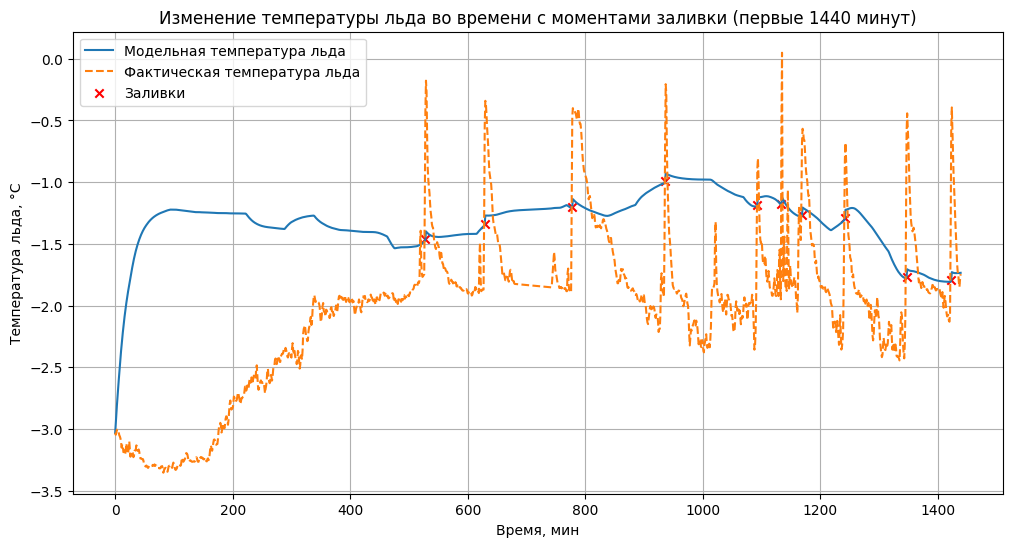

Среднеквадратичная ошибка (MSE) первых 1440 минут: 0.9146 °C²


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
from datetime import timedelta

data = pd.read_csv('../data/sample_transformed_data.csv', 
                   usecols=['time', 'temp_ice', 'temp_outside', 'temp_inside', 'power_compressors'])[10000:]

# Преобразование времени и интерполяция
data = (data
    .assign(time=lambda df: pd.to_datetime(df['time']))
    .drop_duplicates(subset=['time'])
    .set_index('time')
    .pipe(lambda df: df.reindex(pd.date_range(start=df.index.min(), 
                                              end=df.index.max(), 
                                              freq='1T')))
)

# Обработка аномальных значений и интерполяция
data = (data
    .assign(temp_ice=lambda df: np.where(df['temp_ice'].between(-10, 3), df['temp_ice'], np.NaN))
    .fillna(method='ffill')
)

# Добавление столбца времени в минутах от начала
data = data.reset_index(names=['time'])
data['time_minutes'] = (data['time'] - data['time'].min()).dt.total_seconds() / 60
time = data['time_minutes'].values                  # Время в минутах
T_air = data['temp_inside'].values                  # Внутренняя температура, °C
T_outside = data['temp_outside'].values             # Внешняя температура, °C
P_compressors = data['power_compressors'].values    # Мощность компрессоров, Вт

# Проверка равномерности временных шагов
dt_array = np.diff(time)
if not np.allclose(dt_array, dt_array[0]):
    raise ValueError("Временные шаги в данных не равномерны. Необходимо адаптировать код для неравномерных шагов.")
dt = 1  # шаг по времени в минутах

# 2. Определение параметров модели
# Физические параметры
area = 1800  # м²
ice_thickness = 0.04  # м (толщина льда)
ice_density = 917  # кг/м³
mass_ice = area * ice_thickness * ice_density  # кг
C_ice = 2100 * mass_ice  # Дж/°C

h_in = 15  # Вт/(м²·°C)
h_out = 8  # Вт/(м²·°C)
eta = 0.5  # КПД системы охлаждения

# Дополнительные параметры
C_water = 4186  # Дж/(кг·°C)
mass_water = 500  # кг
T_water = 50  # °C
duration_resurfacing = 10  # минут
tau = 5  # минут
tau_d = 30  # минут
T_eq = -5  # °C

# 3. Определение моментов заливки (resurfacing)
# Дифференцируем, экспоненциально сглаженный ряд для нахождения заливки
data['diff'] = data['temp_ice'].ewm(span=60).mean().diff()

# Определение заливок, где разница превышает порог 0.03°C
data['flood'] = np.where(data['diff'] > 0.03, 1, 0)

# Создание признака для подсчёта времени между заливками
data['diff_time'] = timedelta(minutes=30)

# Подсчёт правильного количества заливок
flood_indices = data.index[data['flood'] == 1].tolist()
valid_flood_indices = []
last_flood_time = None

for idx in flood_indices:
    current_time = data.at[idx, 'time']
    if last_flood_time is None or (current_time - last_flood_time) >= timedelta(minutes=30):
        valid_flood_indices.append(idx)
        last_flood_time = current_time

# Обновление списка индексов заливок
resurfacing_indices = [int((data.index.get_loc(idx)) / dt) for idx in valid_flood_indices]

# 4. Инициализация массива для температуры льда
n_points = len(time)
T_ice = np.zeros(n_points)
T_ice[0] = data['temp_ice'].iloc[0]

# 5. Моделирование задержки мощности компрессоров
def delayed_power(P_power, delay_steps):
    P_delayed = np.zeros_like(P_power)
    if delay_steps > 0:
        P_delayed[delay_steps:] = P_power[:-delay_steps]
        P_delayed[:delay_steps] = P_power[0]
    else:
        P_delayed = P_power
    return P_delayed

delay_steps = int(tau / dt)
P_comp_delayed = delayed_power(P_compressors, delay_steps)

# 6. Функция для расчета теплового потока от заливки
def resurfacing_heat_flow(T_ice_current, mass_water, C_water, T_water, duration_resurfacing):
    Q = mass_water * C_water * (T_water - T_ice_current)  # Дж
    q_resurfacing = Q / (duration_resurfacing * 60)  # Вт
    return q_resurfacing

# 7. Функция для расчёта производной температуры
def dTdt(T_current, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices):
    if idx >= n_points:
        idx = n_points - 1

    T_air_current = T_air_array[idx]
    T_outside_current = T_outside_array[idx]
    P_comp_current = P_comp_array[idx]

    q_conv = h_in * area * (T_air_current - T_current)       # Вт
    q_ext = h_out * area * (T_outside_current - T_current)   # Вт
    q_in = q_conv + q_ext                                    # Вт
    if idx in resurfacing_indices:
        q_in += resurfacing_heat_flow(T_current, mass_water, C_water, T_water, duration_resurfacing)  # Вт
    q_out = eta * P_comp_current                             # Вт

    q_damping = (C_ice / tau_d) * (T_current - T_eq)         # Дж/мин

    q_in_J_per_min = q_in * 60                               # Дж/мин
    q_out_J_per_min = q_out * 60                             # Дж/мин

    dT = (q_in_J_per_min - q_out_J_per_min - q_damping) / C_ice  # °C/мин

    return dT

# 8. Реализация метода Рунге-Кутты 4-го порядка
def runge_kutta_step(T_prev, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices):
    def derivative(T, idx):
        return dTdt(T, idx, T_air_array, T_outside_array, P_comp_array, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)
    
    k1 = derivative(T_prev, idx)
    k2 = derivative(T_prev + 0.5 * dt * k1, idx + int(0.5 * dt))
    k3 = derivative(T_prev + 0.5 * dt * k2, idx + int(0.5 * dt))
    k4 = derivative(T_prev + dt * k3, idx + dt)
    
    return T_prev + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Интегрирование методом Рунге-Кутты 4-го порядка
for i in tqdm(range(1, n_points)):
    T_prev = T_ice[i-1]
    T_ice[i] = runge_kutta_step(T_prev, i-1, T_air, T_outside, P_comp_delayed, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)

# 9. Визуализация результатов
flood_times = data['time_minutes'].iloc[resurfacing_indices].values

plt.figure(figsize=(12, 6))
plt.plot(time[:1440], T_ice[:1440], label='Модельная температура льда')
plt.plot(time[:1440], data['temp_ice'].values[:1440], label='Фактическая температура льда', linestyle='--')

# Добавление точек заливки
resurfacing_indices_subset = [idx for idx in resurfacing_indices if idx < 1440]
plt.scatter(time[resurfacing_indices_subset], T_ice[resurfacing_indices_subset], color='red', label='Заливки', marker='x')

plt.xlabel('Время, мин')
plt.ylabel('Температура льда, °C')
plt.title('Изменение температуры льда во времени с моментами заливки (первые 1440 минут)')
plt.grid(True)
plt.legend()
plt.show()

# 10. Вычисление средней квадратичной ошибки (MSE)
from sklearn.metrics import mean_squared_error

T_measured = data['temp_ice'].values[:1440]
T_model = T_ice[:1440]
mse = mean_squared_error(T_measured, T_model)
print(f"Среднеквадратичная ошибка (MSE) первых 1440 минут: {mse:.4f} °C²")


In [73]:
# Функция ошибки для оптимизации
def objective(params):
    h_in_opt, h_out_opt, eta_opt, mass_water_opt = params
    T_ice_opt = np.zeros(n_points)
    T_ice_opt[0] = data['temp_ice'].iloc[0]
    P_comp_delayed_opt = delayed_power(P_compressors, int(tau / dt))
    for i in range(1, n_points):
        T_prev = T_ice_opt[i-1]
        T_ice_opt[i] = runge_kutta_step(T_prev, i-1, T_air, T_outside, P_comp_delayed_opt, h_in_opt, h_out_opt, eta_opt, C_ice, area, tau_d, T_eq, resurfacing_indices)
    mse = mean_squared_error(T_measured, T_ice_opt[:1440])
    return mse

# Начальные догадки для параметров
initial_guess = [h_in, h_out, eta, mass_water]

# Ограничения для параметров
bounds = [(10, 20), (5, 15), (0.4, 0.6), (400, 600)]

# Оптимизация параметров
result = minimize(
    objective, 
    initial_guess, 
    bounds=bounds,
    method='L-BFGS-B'
)

# Оптимизированные параметры
h_in_opt, h_out_opt, eta_opt, mass_water_opt = result.x
print(f"Оптимизированные параметры:\nh_in = {h_in_opt:.2f} Вт/(м²·°C)\nh_out = {h_out_opt:.2f} Вт/(м²·°C)\neta = {eta_opt:.2f}\nmass_water = {mass_water_opt:.2f} кг")

# Обновляем параметры модели
h_in = h_in_opt
h_out = h_out_opt
eta = eta_opt
mass_water = mass_water_opt

# Перезапуск модели с оптимизированными параметрами
T_ice = np.zeros(n_points)
T_ice[0] = data['temp_ice'].iloc[0]
P_comp_delayed = delayed_power(P_compressors, int(tau / dt))
for i in tqdm(range(1, n_points)):
    T_prev = T_ice[i-1]
    T_ice[i] = runge_kutta_step(T_prev, i-1, T_air, T_outside, P_comp_delayed, h_in, h_out, eta, C_ice, area, tau_d, T_eq, resurfacing_indices)

# Вычисление новой MSE
T_model = T_ice[:1440]
mse = mean_squared_error(T_measured, T_model)
print(f"Среднеквадратичная ошибка (MSE) после оптимизации: {mse:.4f} °C²")

Оптимизированные параметры:
h_in = 11.12 Вт/(м²·°C)
h_out = 5.00 Вт/(м²·°C)
eta = 0.40
mass_water = 500.00 кг


100%|██████████| 34083/34083 [00:00<00:00, 70417.28it/s]

Среднеквадратичная ошибка (MSE) после оптимизации: 0.3987 °C²


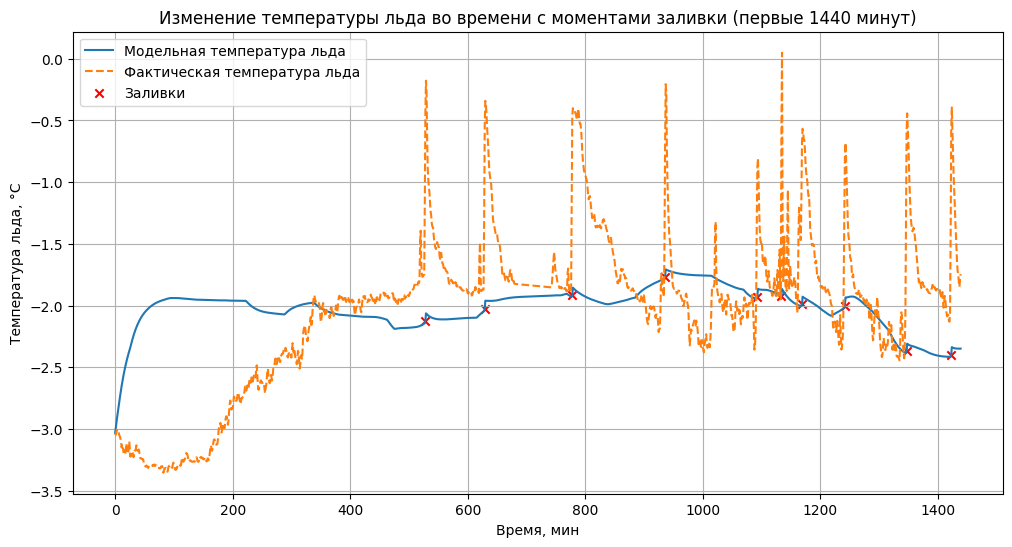

In [74]:
# 9. Визуализация результатов
flood_times = data['time_minutes'].iloc[resurfacing_indices].values

plt.figure(figsize=(12, 6))
plt.plot(time[:1440], T_ice[:1440], label='Модельная температура льда')
plt.plot(time[:1440], data['temp_ice'].values[:1440], label='Фактическая температура льда', linestyle='--')

# Добавление точек заливки
resurfacing_indices_subset = [idx for idx in resurfacing_indices if idx < 1440]
plt.scatter(time[resurfacing_indices_subset], T_ice[resurfacing_indices_subset], color='red', label='Заливки', marker='x')

plt.xlabel('Время, мин')
plt.ylabel('Температура льда, °C')
plt.title('Изменение температуры льда во времени с моментами заливки (первые 1440 минут)')
plt.grid(True)
plt.legend()
plt.show()
